In [1]:
import tensorflow as tf
import keras 
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import time

dataset = torchvision.datasets.MNIST(root='./data', transform=transforms.ToTensor(), train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', transform=transforms.ToTensor(), train=False, download=True)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1000, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=2000, shuffle=False)

Using TensorFlow backend.


In [2]:
def create_robust_dataset(size_of_dataset):
    import random
    random_batch_idx = (random.randint(0, len(loader)-1))
    samples, labels = None, None 
    for idx, (samples, labels) in enumerate(loader):
        if idx == random_batch_idx:
            samples = samples.reshape(-1, 784).numpy()
            labels = labels.numpy()
            samples = samples[:size_of_dataset]
            labels = labels[:size_of_dataset]
            break
    
    return samples, labels

def create_non_robust_dataset(size_of_dataset):
    import random
    random_batch_idx = (random.randint(0, len(loader)-1))
    samples, labels = None, None 
    for idx, (samples, labels) in enumerate(loader):
        if idx == random_batch_idx:
            samples = samples.reshape(-1, 784).numpy()
            labels = labels.numpy()
            samples = samples[:size_of_dataset]
            labels = labels[:size_of_dataset]
            break
    
    return samples, labels

def create_test_dataset(size_of_dataset):
    samples, labels = None, None 
    for idx, (samples, labels) in enumerate(test_loader):
        if idx == 0:
            samples = samples.reshape(-1, 784).numpy()
            labels = labels.numpy()
            samples = samples[:size_of_dataset]
            labels = labels[:size_of_dataset]
            break
    
    return samples, labels

    
size_of_dataset = 600
robust_X, robust_Y = create_robust_dataset(size_of_dataset)
print(robust_X.shape, robust_Y.shape)
non_robust_X, non_robust_Y = create_non_robust_dataset(size_of_dataset)
print(non_robust_X.shape, non_robust_Y.shape)

test_X, test_Y = create_test_dataset(1000)
print(test_X.shape, test_Y.shape)

(600, 784) (600,)
(600, 784) (600,)
(1000, 784) (1000,)


In [3]:
from math import inf
from numpy.linalg import norm

num_classes = 10

def return_close_i(i, X_cluster_mean):
    min_j, min_distance = None, inf
    for j in range(len(X_cluster_mean)):
        if i != j:
            distance = norm(X_cluster_mean[j] - X_cluster_mean[i])
            if distance < min_distance:
                min_distance, min_j = distance, j
    return min_j, min_distance

def compute_robustness_indication(X, Y):
    X_cluster = []
    for class_idx in range(num_classes):
        cluster_array = [x for (idx, x) in enumerate(X) if Y[idx] == class_idx]
#         print('Length of cluster array:', len(cluster_array))
        try: 
            cluster = np.array(cluster_array)
        except: 
            print(cluster_array)
            cluster = np.array(cluster_array)
            print(cluster)
        X_cluster.append(cluster)
        
    
    X_cluster_mean = [np.mean(X, axis=0) for X in X_cluster]
    X_cluster_std = [np.std(X, axis=0) for X in X_cluster]

    r = 0
    for i in range(num_classes):
        close_i, close_i_distance = return_close_i(i, X_cluster_mean)
        r += close_i_distance - norm(X_cluster_std[i]) - norm(X_cluster_std[close_i])
    return r

robust_r = compute_robustness_indication(robust_X, robust_Y)
non_robust_r = compute_robustness_indication(non_robust_X, non_robust_Y)

print('Robustness indication (robust dataset):', robust_r)
print('Robustness indication (non robust dataset):', non_robust_r)

Robustness indication (robust dataset): -91.50874376296997
Robustness indication (non robust dataset): -89.11045217514038


In [4]:
# Create two models corresponding to robust and non-robust dataset 
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class NaiveC(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(784, 64)
        self.layer2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.relu(self.layer1(x))
        return self.layer2(output)

class NormalC(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(784, 64)
        self.layer2 = nn.Linear(64, 16)
        self.layer3 = nn.Linear(16, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        h1 = self.relu(self.layer1(x))
        h2 = self.relu(self.layer2(h1))
        return self.layer3(h2)
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

def generate_Cs(X, Y, verbose=False):
    first_model = NaiveC()
    second_model = NormalC()
    
    # Create ResNet
    
    third_model = Net()
    third_optimizer = optim.SGD(third_model.parameters(), lr=0.01, momentum=0.5)

    # Optimizer parameters
    loss_func = nn.CrossEntropyLoss()
    lr = 1e-3
    first_optimizer = torch.optim.Adam(first_model.parameters(), lr=lr)
    second_optimizer = torch.optim.Adam(second_model.parameters(), lr=lr)
    loss_history = []

    # Training
    num_of_epochs = 20
    for epoch in range(num_of_epochs):
        print(epoch+1, '/', num_of_epochs)
        for idx, data in enumerate(X):
            data = torch.from_numpy(np.expand_dims(data, axis=0).astype(np.float32))
            label = torch.from_numpy(np.array([Y[idx]]).astype(np.int64))
    
            # Forwarding (First model)
            prediction = first_model.forward(data)
            loss = loss_func(prediction, label)
            if verbose:
                print('Epoch:', epoch, 'Loss:', loss)

            # Optimization (back-propogation)
            first_optimizer.zero_grad()
            loss.backward()
            first_optimizer.step()
            loss_history.append(loss.item())
            
            # Forwarding (Second model)
            prediction = second_model.forward(data)
            loss = loss_func(prediction, label)
            if verbose:
                print('Epoch:', epoch, 'Loss:', loss)

            # Optimization (back-propogation)
            second_optimizer.zero_grad()
            loss.backward()
            second_optimizer.step()
            loss_history.append(loss.item())
            
            # Forwarding (Third model)
            train  = data.resize(1, 1, 28, 28)
            third_optimizer.zero_grad()
            output = third_model(train)
            loss = F.nll_loss(output, label)
            third_optimizer.zero_grad()
            loss.backward()
            third_optimizer.step()
            
    models = [first_model, second_model, third_model]
    return loss_history, models
            
robust_loss_history, robust_models = generate_Cs(robust_X, robust_Y, verbose=False)
non_robust_loss_history, non_robust_models = generate_Cs(non_robust_X, non_robust_Y, verbose=False)

1 / 20


//anaconda3/lib/python3.7/site-packages/torch/tensor.py:293: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20


In [5]:
def eval_model(X, Y, model):
    datas = torch.from_numpy(X.astype(np.float32))
    labels = torch.from_numpy(Y.astype(np.int64))
    
    # Forwarding
    try:
        outputs = model.forward(datas).detach().numpy()
    except:
        train  = datas.resize(X.shape[0], 1, 28, 28)
        outputs = model.forward(train).detach().numpy()
        
    predictions = np.argmax(outputs, axis=1)

    total = labels.shape[0]
    correct = (predictions == labels.numpy()).sum().item()
    acc = correct/total
    
    return acc

for robust_model in robust_models:
    robust_acc = eval_model(robust_X, robust_Y, robust_model)
    print('Robust model accurancy:', robust_acc)

for non_robust_model in non_robust_models:
    non_robust_acc = eval_model(non_robust_X, non_robust_Y, non_robust_model)
    print('Non robust model accurancy:', non_robust_acc)

Robust model accurancy: 1.0
Robust model accurancy: 1.0
torch.Size([600, 1, 28, 28])
Robust model accurancy: 0.605
Non robust model accurancy: 1.0
Non robust model accurancy: 1.0
torch.Size([600, 1, 28, 28])
Non robust model accurancy: 0.755


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


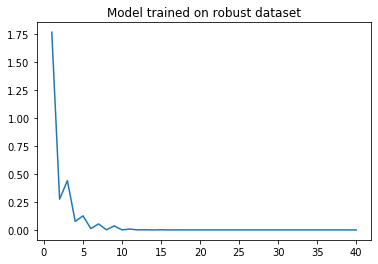

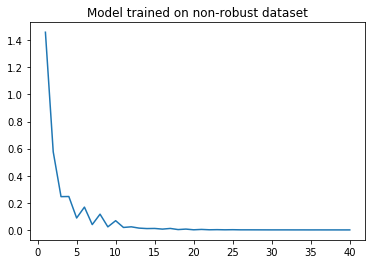

In [6]:
# Visualize the training process 
%matplotlib inline 
import matplotlib.pyplot as plt

y = [robust_loss_history[i] for i in np.arange(len(robust_loss_history)) if (i+1)%size_of_dataset==0]
x = [i+1 for i in np.arange(len(y))]
x = np.array(x)
plt.plot(x, y)
plt.title('Model trained on robust dataset')
plt.show()

y = [non_robust_loss_history[i] for i in np.arange(len(non_robust_loss_history)) if (i+1)%size_of_dataset==0]
x = [i+1 for i in np.arange(len(y))]
x = np.array(x)
plt.plot(x, y)
plt.title('Model trained on non-robust dataset')
plt.show()

In [13]:
# Measure attack success rate 
# 1. Design (apply) adversarial attacks 
def fgsm_attack(image, epsilon, data_grad):
    
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + (epsilon * sign_data_grad)
    # Return the perturbed image
    return perturbed_image

def test(model, epsilon, X, Y, verbose=False):

    # Accuracy counter
    correct = 0
    success_count = 0
    adv_examples = []

    # Loop over all examples in test set
    for idx, data in enumerate(X):
        data = torch.from_numpy(np.expand_dims(data, axis=0).astype(np.float32))
            
        target = np.array([Y[idx]]).astype(np.int64)
        target = torch.from_numpy(target)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        try: 
            output = model.forward(data)
        except:
            train  = data.resize(X.shape[0], 1, 28, 28)
            outputs = model.forward(train).detach().numpy()
        
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model.forward(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
        else:
            success_count += 1

    # Calculate final accuracy for this epsilon
    final_sucess_rate = success_count/float(Y.shape[0])
    if verbose:
        print("Epsilon: {}\tSuccess Rate = {} / {} = {}".format(epsilon, success_count, Y.shape[0], final_sucess_rate))
    
    return final_sucess_rate

# epsilons = [0, .01, .02, .03, .05, .1, .15, .2]
for (robust_model, non_robust_model) in zip(robust_models, non_robust_models):
    epsilons = [.01]
    robust_pretrained_model = robust_model.eval()
    non_robust_pretrained_model = non_robust_model.eval()
    use_cuda=False

    robust_attack_success_rate, non_robust_attack_success_rate = [], []
    # Run test for each epsilon (robust)
    for eps in epsilons:
        start = time.time()
        robust_attack_success_rate.append(test(robust_model, eps, test_X, test_Y, verbose=True))
        end = time.time()
#         print(end - start)

    # Run test for each epsilon (non robust)
    for eps in epsilons:
        start = time.time()
        non_robust_attack_success_rate.append(test(non_robust_model, eps, test_X, test_Y, verbose=True))
        end = time.time()
#         print(end - start)
    print()

Epsilon: 0.01	Success Rate = 55 / 1000 = 0.055
Epsilon: 0.01	Success Rate = 57 / 1000 = 0.057

Epsilon: 0.01	Success Rate = 72 / 1000 = 0.072
Epsilon: 0.01	Success Rate = 76 / 1000 = 0.076



RuntimeError: requested resize to 1000x1x28x28 (784000 elements in total), but the given tensor has a size of 1x784 (784 elements). autograd's resize can only change the shape of a given tensor, while preserving the number of elements. 

In [ ]:
## print('Robustness indication (robust dataset):', robust_r)
print('Robustness indication (non robust dataset):', non_robust_r)

great_indication_count = 0
num_of_comparision = len(robust_attack_success_rate)
if robust_r < non_robust_r:
    for i in range(num_of_comparision):
        if robust_attack_success_rate[i] >= non_robust_attack_success_rate[i]:
            great_indication_count += 1
elif robust_r > non_robust_r:
    for i in range(num_of_comparision):
        if robust_attack_success_rate[i] <= non_robust_attack_success_rate[i]:
            great_indication_count += 1
else:
    print('Weird, it merely impossible for two robustness indication to the same!')

print(great_indication_count, num_of_comparision, great_indication_count/num_of_comparision)

In [ ]:
num_of_trails = 500                
cum_related_rate = 0

time_record_for_adv_est_r = []
time_record_for_real_r = []

for trail_idx in range(num_of_trails):
    print('Trail:', trail_idx+1)

    size_of_dataset = 500
    robust_X, robust_Y = create_robust_dataset(size_of_dataset)
    non_robust_X, non_robust_Y = create_non_robust_dataset(size_of_dataset)

    start = time.time()
    robust_r = compute_robustness_indication(robust_X, robust_Y)
    end = time.time()
    time_escape = end - start 
    time_record_for_adv_est_r.append(time_escape)
        
    non_robust_r = compute_robustness_indication(non_robust_X, non_robust_Y)

    robust_loss_history, robust_model = generate_NaiveC(robust_X, robust_Y)
    non_robust_loss_history, non_robust_model = generate_NaiveC(non_robust_X, non_robust_Y)

    
#     epsilons = [.02, .03, 0.5, 0.8, .1]
    epsilons = [.1]
    
    
    robust_pretrained_model = robust_model.eval()
    non_robust_pretrained_model = non_robust_model.eval()
    use_cuda=False

    robust_attack_success_rate, non_robust_attack_success_rate = [], []
    # Run test for each epsilon (robust)
    for eps in epsilons:
        start = time.time()
        robust_attack_success_rate.append(test(robust_model, eps, test_X, test_Y))
        end = time.time()
        time_escape = end - start 
        time_record_for_real_r.append(time_escape)
        
    # Run test for each epsilon (non robust)
    for eps in epsilons:
        non_robust_attack_success_rate.append(test(non_robust_model, eps, test_X, test_Y))

    great_indication_count = 0
    num_of_comparision = len(robust_attack_success_rate)
    if robust_r < non_robust_r:
        for i in range(num_of_comparision):
            if robust_attack_success_rate[i] >= non_robust_attack_success_rate[i]:
                great_indication_count += 1
    elif robust_r > non_robust_r:
        for i in range(num_of_comparision):
            if robust_attack_success_rate[i] <= non_robust_attack_success_rate[i]:
                great_indication_count += 1
    else:
        print('Weird, it merely impossible for two robustness indication to the same!')

    print(great_indication_count, num_of_comparision, great_indication_count/num_of_comparision)
    cum_related_rate += great_indication_count/num_of_comparision
    
print(cum_related_rate/num_of_trails)

In [ ]:
print(np.mean(np.array(time_record_for_adv_est_r)))
print(np.mean(np.array(time_record_for_real_r)))